In [1]:
library(IRdisplay)
display_html("<style>.container { width:100% !important; }</style>")

In [2]:
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(purrr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(optparse))
#suppressPackageStartupMessages(library(assertthat))
suppressPackageStartupMessages(library(tools))
suppressPackageStartupMessages(library(cowplot))
#suppressPackageStartupMessages(library(gridExtra))
#suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(umap))
suppressPackageStartupMessages(library(ggpubr))

In [3]:
opts <- list()
opts$input.meta <- "/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/10x_gastrulation_DNMTs_Data/results/mapping/merged/mapping/mnn/mapping_mnn.txt.gz"
opts$atlas.metadata <- "/nfs/research1/marioni/Leah/gastrulation10x/data/fromRpackage/atlas_metadata.txt.gz"
opts$settings <- "/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/mapping_DNMT/evaluating/settings.R"
#opts$output.base <- "/nfs/research1/marioni/Leah/scNMTseq/ModelSystems/TettKOchimera/processed_files_Leah/plots/mnn/WT/"
opts$plot.type <- "pdf"

In [4]:
source(opts$settings)

if (!is.null(io$plot.type)) opts$plot.type <- io$plot.type

In [15]:
message("Loading input...")

# Load atlas metadata
if (file_ext(opts$atlas.metadata) == "rds") {
    meta_atlas <- readRDS(paste0(opts$atlas.metadata)) %>% as.data.table
} else {
    meta_atlas <- fread(opts$atlas.metadata, sep="\t", na="NA", quote=F) %>% as.data.table
}

# Load query metadata
meta_merge <- fread(opts$input.meta)[(pass_QC==T) & (stage=="E8.5")]

Loading input...



In [16]:
meta_merge

cell,orig.ident,nCount_RNA,nFeature_RNA,barcode,batch,stage,class,target,modification,⋯,collection,Dnmt3a,lib_num,orig.cell,index,celltype.mapped,stage.mapped,closest.cell,celltype.score,cellstage.score
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
cell_10000_fourth_batch,cell,21983,4267,GTTATGGAGAGTCGAC-1,2_E8_5_D3A_WT_D3B_KO_L003,E8.5,E85_Dnmt3aWT_Dnmt3bKO,Dnmt3a_Dnmt3b,SingleMutant,⋯,fourth_batch,WT,2,cell_10000,NA,Somitic mesoderm,E8.0,cell_66588,0.9666667,0.4666667
cell_10000_third_batch,cell,84933,7982,TGAACGTGTGGACTGA-1,SIGAA6_E85_2_Dnmt3aKO_Dnmt3b_WT_L001,E8.5,E85_Dnmt3aKO_Dnmt3bWT,Dnmt3a_Dnmt3b,SingleMutant,⋯,third_batch,KO,NA,cell_10000,SIGAA6,Surface ectoderm,E8.5,cell_37475,1.0000000,0.5666667
cell_10002_third_batch,cell,40600,5565,TGAATCGAGCTGTCCG-1,SIGAA6_E85_2_Dnmt3aKO_Dnmt3b_WT_L001,E8.5,E85_Dnmt3aKO_Dnmt3bWT,Dnmt3a_Dnmt3b,SingleMutant,⋯,third_batch,KO,NA,cell_10002,SIGAA6,Haematoendothelial progenitors,E8.0,cell_123589,1.0000000,0.3333333
cell_10003_third_batch,cell,29204,5013,TGAATCGAGGCCCAAA-1,SIGAA6_E85_2_Dnmt3aKO_Dnmt3b_WT_L001,E8.5,E85_Dnmt3aKO_Dnmt3bWT,Dnmt3a_Dnmt3b,SingleMutant,⋯,third_batch,KO,NA,cell_10003,SIGAA6,Pharyngeal mesoderm,E8.25,cell_114931,1.0000000,0.5333333
cell_10004_third_batch,cell,25286,4842,TGAATCGAGGCTAAAT-1,SIGAA6_E85_2_Dnmt3aKO_Dnmt3b_WT_L001,E8.5,E85_Dnmt3aKO_Dnmt3bWT,Dnmt3a_Dnmt3b,SingleMutant,⋯,third_batch,KO,NA,cell_10004,SIGAA6,Pharyngeal mesoderm,E8.0,cell_39100,0.9666667,0.4333333
cell_10005_fourth_batch,cell,22542,4844,GTTATGGCACATATGC-1,2_E8_5_D3A_WT_D3B_KO_L003,E8.5,E85_Dnmt3aWT_Dnmt3bKO,Dnmt3a_Dnmt3b,SingleMutant,⋯,fourth_batch,WT,2,cell_10005,NA,Mesenchyme,E8.5,cell_101629,1.0000000,0.9333333
cell_10005_third_batch,cell,28177,3392,TGAATCGCATGACAAA-1,SIGAA6_E85_2_Dnmt3aKO_Dnmt3b_WT_L001,E8.5,E85_Dnmt3aKO_Dnmt3bWT,Dnmt3a_Dnmt3b,SingleMutant,⋯,third_batch,KO,NA,cell_10005,SIGAA6,Erythroid3,E8.5,cell_138186,0.7666667,0.9333333
cell_10007_fourth_batch,cell,35222,4565,GTTATGGCACCTTCCA-1,2_E8_5_D3A_WT_D3B_KO_L003,E8.5,E85_Dnmt3aWT_Dnmt3bKO,Dnmt3a_Dnmt3b,SingleMutant,⋯,fourth_batch,WT,2,cell_10007,NA,Erythroid3,E8.5,cell_102032,1.0000000,0.9666667
cell_10007_third_batch,cell,47192,5947,TGAATCGGTTAGTCGT-1,SIGAA6_E85_2_Dnmt3aKO_Dnmt3b_WT_L001,E8.5,E85_Dnmt3aKO_Dnmt3bWT,Dnmt3a_Dnmt3b,SingleMutant,⋯,third_batch,KO,NA,cell_10007,SIGAA6,ExE endoderm,E8.25,cell_94949,1.0000000,0.4000000


In [17]:
unique(meta_merge$batch)

[1] "2_E8_5_D3A_WT_D3B_KO_L003"            
 [2] "SIGAA6_E85_2_Dnmt3aKO_Dnmt3b_WT_L001" 
 [3] "SIGAB6_E85_3_Dnmt3aWT_Dnmt3b_WT_L002" 
 [4] "3_E8_5_D3A_HET_D3B_WT_L004"           
 [5] "7_E8_5_D3A_WT_D3B_KO_L005"            
 [6] "SIGAC6_E85_5_Dnmt3aKO_Dnmt3b_Het_L003"
 [7] "SIGAD6_E85_8_Dnmt3aHet_Dnmt3b_KO_L004"
 [8] "8_E8_5_D3A_KO_D3B_KO_L006"            
 [9] "15_E8_5_D3A_WT_D3B_WT_L007"           
[10] "17_E8_5_D3A_KO_D3B_WT_L008"

In [18]:
unique(meta_merge$class)

[1] "E85_Dnmt3aWT_Dnmt3bKO"  "E85_Dnmt3aKO_Dnmt3bWT"  "E85_Dnmt3aWT_Dnmt3bWT" 
[4] "E85_Dnmt3aHET_Dnmt3bWT" "E85_Dnmt3aKO_Dnmt3bHet" "E85_Dnmt3aHet_Dnmt3bKO"
[7] "E85_Dnmt3aKO_Dnmt3bKO"

In [19]:
unique(meta_merge[,c("class", "batch")])[,.N,by=class]

class,N
<chr>,<int>
E85_Dnmt3aWT_Dnmt3bKO,2
E85_Dnmt3aKO_Dnmt3bWT,2
E85_Dnmt3aWT_Dnmt3bWT,2
E85_Dnmt3aHET_Dnmt3bWT,1
E85_Dnmt3aKO_Dnmt3bHet,1
E85_Dnmt3aHet_Dnmt3bKO,1
E85_Dnmt3aKO_Dnmt3bKO,1


In [58]:
mean_ct_class

,Epiblast,Primitive Streak,Caudal epiblast,PGC,Anterior Primitive Streak,Notochord,Def. endoderm,Gut,Nascent mesoderm,Mixed mesoderm,⋯,Rostral neurectoderm,Caudal neurectoderm,Neural crest,Forebrain/Midbrain/Hindbrain,Spinal cord,Surface ectoderm,Visceral endoderm,ExE endoderm,ExE ectoderm,Parietal endoderm
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
E85_Dnmt3aWT_Dnmt3bKO,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
E85_Dnmt3aKO_Dnmt3bWT,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
E85_Dnmt3aWT_Dnmt3bWT,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
E85_Dnmt3aHET_Dnmt3bWT,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
E85_Dnmt3aKO_Dnmt3bHet,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
E85_Dnmt3aHet_Dnmt3bKO,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
E85_Dnmt3aKO_Dnmt3bKO,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [80]:
mean_ct_class["E85_Dnmt3aWT_Dnmt3bKO", "Epiblast"]

[1] 0

In [79]:
celltypes <- names(celltype_colours)
classes <- unique(meta_merge$class)

meta_ct <- list()

mean_ct_class <- matrix(0, ncol=length(celltypes),nrow=length(classes))
rownames(mean_ct_class) <- classes
colnames(mean_ct_class) <- celltypes

In [175]:
celltypes <- names(celltype_colours)
classes <- unique(meta_merge$class)

meta_ct <- list()

mean_ct_class <- matrix(0, ncol=length(celltypes),nrow=length(classes))
rownames(mean_ct_class) <- classes
colnames(mean_ct_class) <- celltypes

var_ct_class <- mean_ct_class

batch_n <- meta_merge[,.N,by="batch"]

for (ct in celltypes) {
    meta_ct[[ct]] <- meta_merge[celltype.mapped==ct]
    for (cl in classes) {
        
        if (cl %in% meta_ct[[ct]]$class) {

            tmp <- meta_ct[[ct]][class == cl]

            if (length(unique(tmp$batch)) == 1) {
                mean_ct_class[cl, ct] <- dim(tmp)[1]/batch_n[batch==unique(tmp$batch)]$N
            } else {
                tmp2 <- tmp[,.N,by=batch]
                tmp2$batch_n <- batch_n[batch %in% tmp2$batch]$N
                tmp2$prop <- tmp2$N/tmp2$batch_n
                print(tmp2)
                mean_ct_class[cl, ct] <- mean(tmp2$prop)
                var_ct_class[cl, ct] <- (abs(tmp2$prop[1] - tmp2$prop[2])/2)
            }
        
        }
    }
}

                       batch N batch_n         prop
1: 2_E8_5_D3A_WT_D3B_KO_L003 4    5898 0.0006781960
2: 7_E8_5_D3A_WT_D3B_KO_L005 2    6118 0.0003269042
                                  batch N batch_n         prop
1: SIGAA6_E85_2_Dnmt3aKO_Dnmt3b_WT_L001 2    6298 0.0003175611
2:           17_E8_5_D3A_KO_D3B_WT_L008 2    2629 0.0007607455
                       batch N batch_n        prop
1: 2_E8_5_D3A_WT_D3B_KO_L003 9    5898 0.001525941
2: 7_E8_5_D3A_WT_D3B_KO_L005 8    6118 0.001307617
                                  batch N batch_n         prop
1: SIGAB6_E85_3_Dnmt3aWT_Dnmt3b_WT_L002 6    6332 0.0009475679
2:           15_E8_5_D3A_WT_D3B_WT_L007 3    2428 0.0012355848
                       batch N batch_n        prop
1: 2_E8_5_D3A_WT_D3B_KO_L003 6    5898 0.001017294
2: 7_E8_5_D3A_WT_D3B_KO_L005 7    6118 0.001144165
                                  batch N batch_n         prop
1: SIGAA6_E85_2_Dnmt3aKO_Dnmt3b_WT_L001 3    6298 0.0004763417
2:           17_E8_5_D3A_KO_D3B_WT

In [237]:
mean_table <- as.data.table(
    as.table(mean_ct_class),
    stringsAsFactors=FALSE
)
colnames(mean_table) <- c("class", "celltype", "mean")
diff_table <- as.data.table(
    as.table(var_ct_class),
    stringsAsFactors=FALSE
)
colnames(diff_table) <- c("class", "celltype", "diff")
toplot <- merge(mean_table, diff_table, by=c("class","celltype"))
toplot$difftoWT <- 0
toplot$logFC <- 0
for (ct in celltypes) {
    toplot[celltype==ct]$difftoWT <- toplot[celltype==ct]$mean - toplot[(class=="E85_Dnmt3aWT_Dnmt3bWT") & (celltype==ct)]$mean
    if (toplot[(class=="E85_Dnmt3aWT_Dnmt3bWT") & (celltype==ct)]$mean > 0) {
        toplot[celltype==ct]$logFC <- log2(toplot[celltype==ct]$mean/toplot[(class=="E85_Dnmt3aWT_Dnmt3bWT") & (celltype==ct)]$mean)
    } else {
        toplot[celltype==ct]$logFC <- NA
    }
}
toplot

class,celltype,mean,diff,difftoWT,logFC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
E85_Dnmt3aHET_Dnmt3bWT,Allantois,0.0239702118,0,-9.873469e-03,-0.49764383
E85_Dnmt3aHET_Dnmt3bWT,Anterior Primitive Streak,0.0000000000,0,0.000000e+00,NA
E85_Dnmt3aHET_Dnmt3bWT,Blood progenitors 1,0.0000000000,0,-1.517358e-03,-Inf
E85_Dnmt3aHET_Dnmt3bWT,Blood progenitors 2,0.0000000000,0,-5.979669e-03,-Inf
E85_Dnmt3aHET_Dnmt3bWT,Cardiomyocytes,0.0591110077,0,3.297367e-02,1.17731440
E85_Dnmt3aHET_Dnmt3bWT,Caudal Mesoderm,0.0018617640,0,-1.207034e-03,-0.72100361
E85_Dnmt3aHET_Dnmt3bWT,Caudal epiblast,0.0004654410,0,-8.342949e-06,-0.02563102
E85_Dnmt3aHET_Dnmt3bWT,Caudal neurectoderm,0.0004654410,0,4.654410e-04,NA
E85_Dnmt3aHET_Dnmt3bWT,Def. endoderm,0.0076797766,0,3.584446e-03,0.90708456


In [ ]:
toplot$difftoWTmin <- toplot$difftoWT-toplot$diff
toplot$difftoWTmax <- toplot$difftoWT+toplot$diff

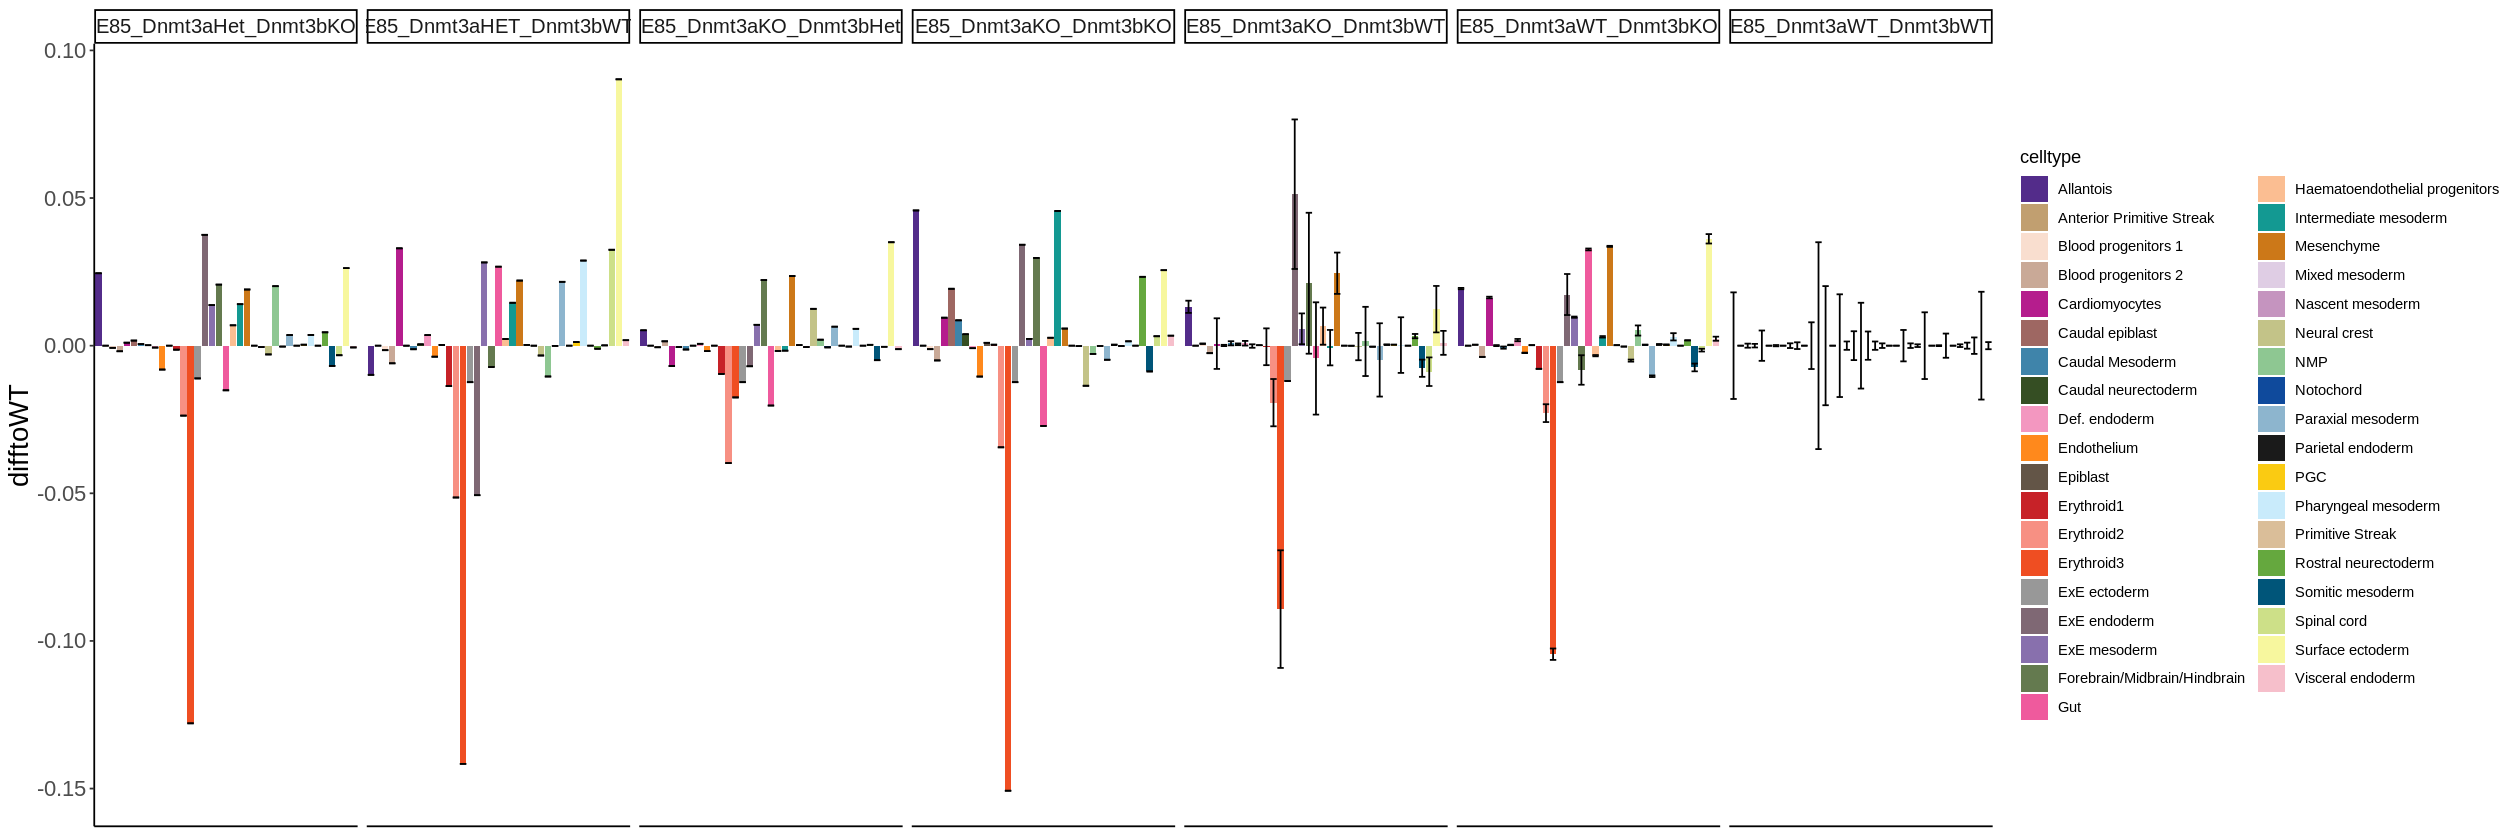

In [266]:
w=21
options(repr.plot.width=w, repr.plot.height=w/3)
ggplot(toplot, aes(x=celltype, y=difftoWT, fill=celltype)) + 
    geom_bar(position="dodge", stat="identity") +
    scale_fill_manual(values=celltype_colours, drop=F) +
    facet_wrap(~class, nrow = 1) +
    theme_classic() +
    geom_errorbar( aes(x=celltype, ymin=difftoWT-diff, ymax=difftoWT+diff)) +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          strip.text=element_text(size=rel(1.1)),
          axis.text.y=element_text(size=rel(1.5)),
          axis.title.y=element_text(size=rel(1.5)))

Warning message:
“Removed 42 rows containing missing values (geom_bar).”


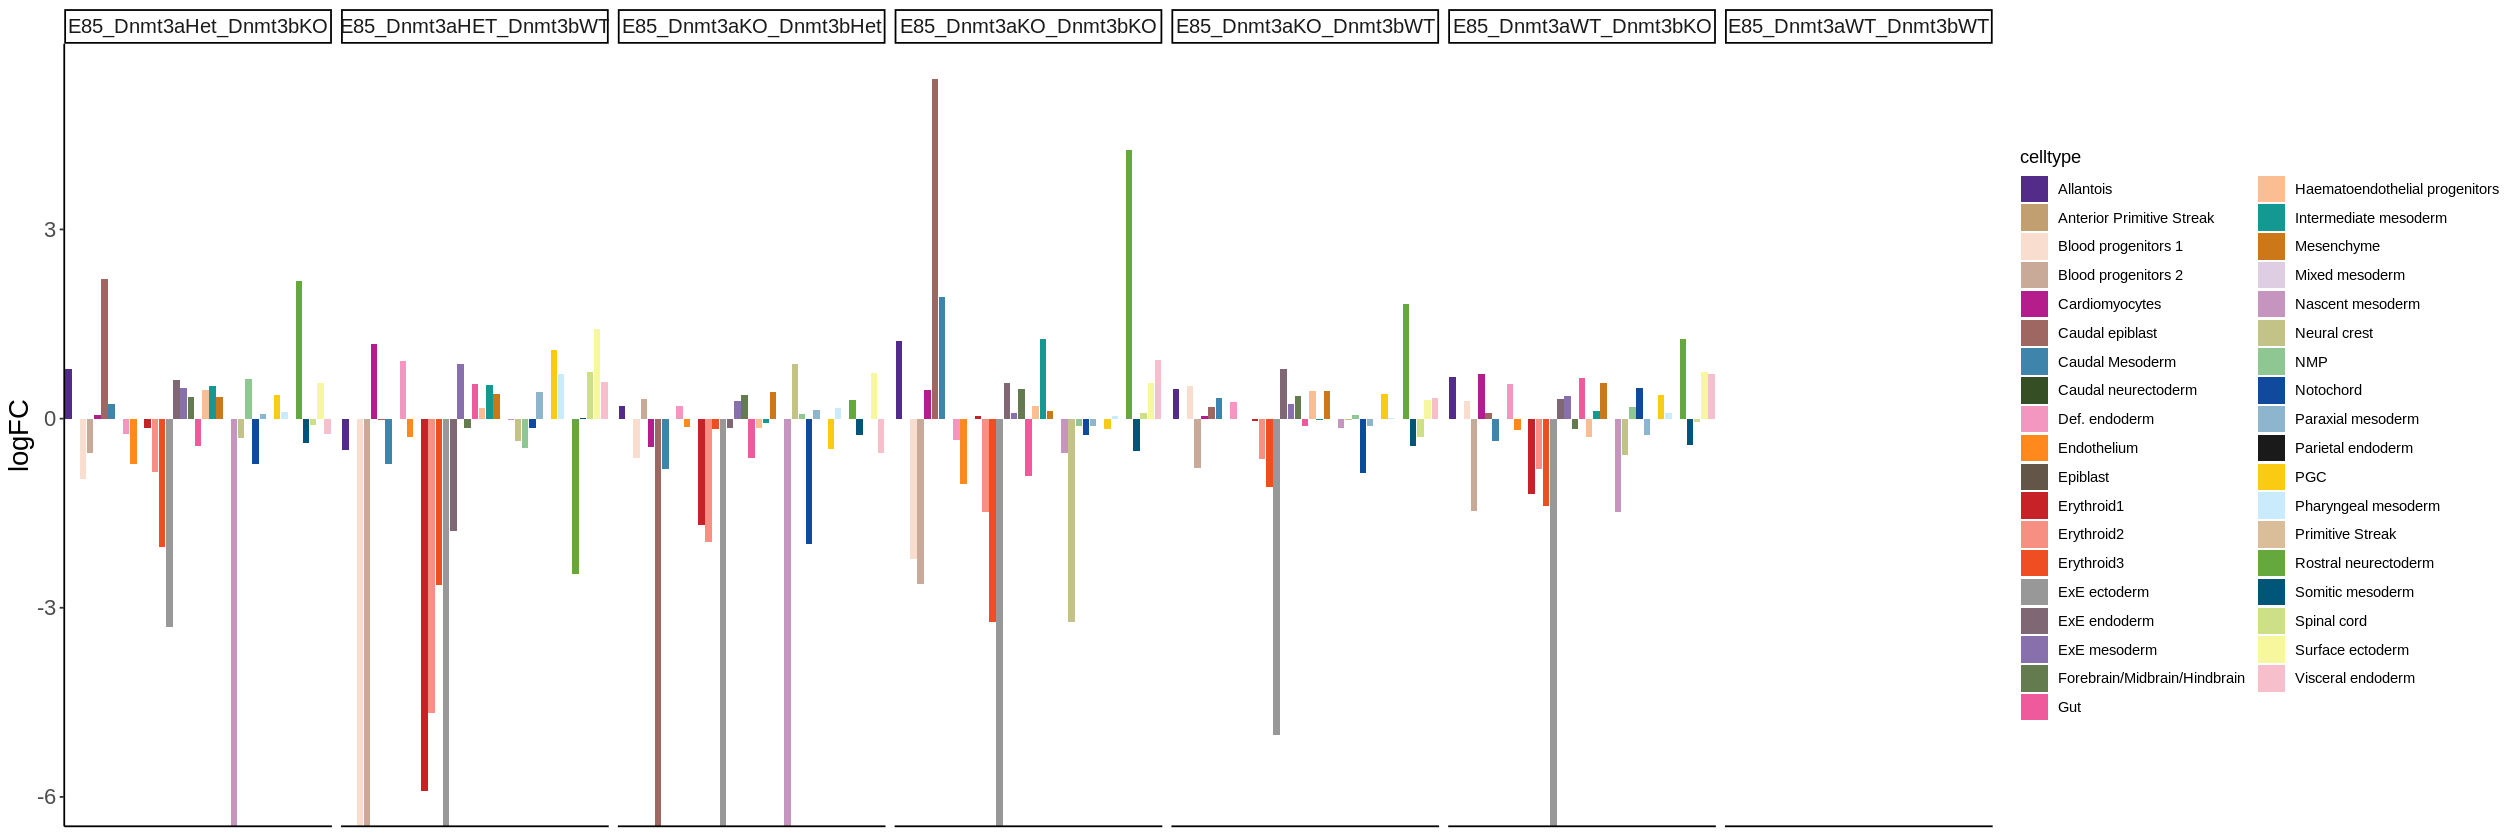

In [264]:
w=21
options(repr.plot.width=w, repr.plot.height=w/3)
ggplot(toplot, aes(x=celltype, y=logFC, fill=celltype)) + 
    geom_bar(position="dodge", stat="identity") +
    scale_fill_manual(values=celltype_colours, drop=F) +
    facet_wrap(~class, nrow = 1) +
    theme_classic() +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank(),
          strip.text=element_text(size=rel(1.1)),
          axis.text.y=element_text(size=rel(1.5)),
          axis.title.y=element_text(size=rel(1.5)))

In [212]:
subset_celltypes <- list(
    "Haematoendothelial" = c("Haematoendothelial progenitors", "Blood progenitors 1", "Blood progenitors 2", "Erythroid1", "Erythroid2", "Erythroid3", "Endothelium", "Cardiomyocytes"),
    "Endoderm" = c("ExE endoderm", "Visceral endoderm", "Gut", "Def. endoderm", "Notochord"),
    "EpiblastPSNeuro" = c("Epiblast", "Primitive Streak", "Rostral neurectoderm", "Spinal cord", "Surface ectoderm", "Nascent mesoderm", "NMP", "Neural crest", "Caudal neurectoderm", "Caudal epiblast", "Anterior Primitive Streak", "Forebrain/Midbrain/Hindbrain", "PGC"),
    "Mesoderm" = c("Nascent mesoderm", "Mesenchyme", "Mixed mesoderm", "ExE mesoderm, Intermediate mesoderm", "Pharyngeal mesoderm", "Paraxial mesoderm", "Somitic mesoderm", "Caudal Mesoderm", "Allantois"),
    "ParietalEndoderm" = c("Parietal Endoderm"),
    "ExEectoderm" = c("ExE ectoderm")
)

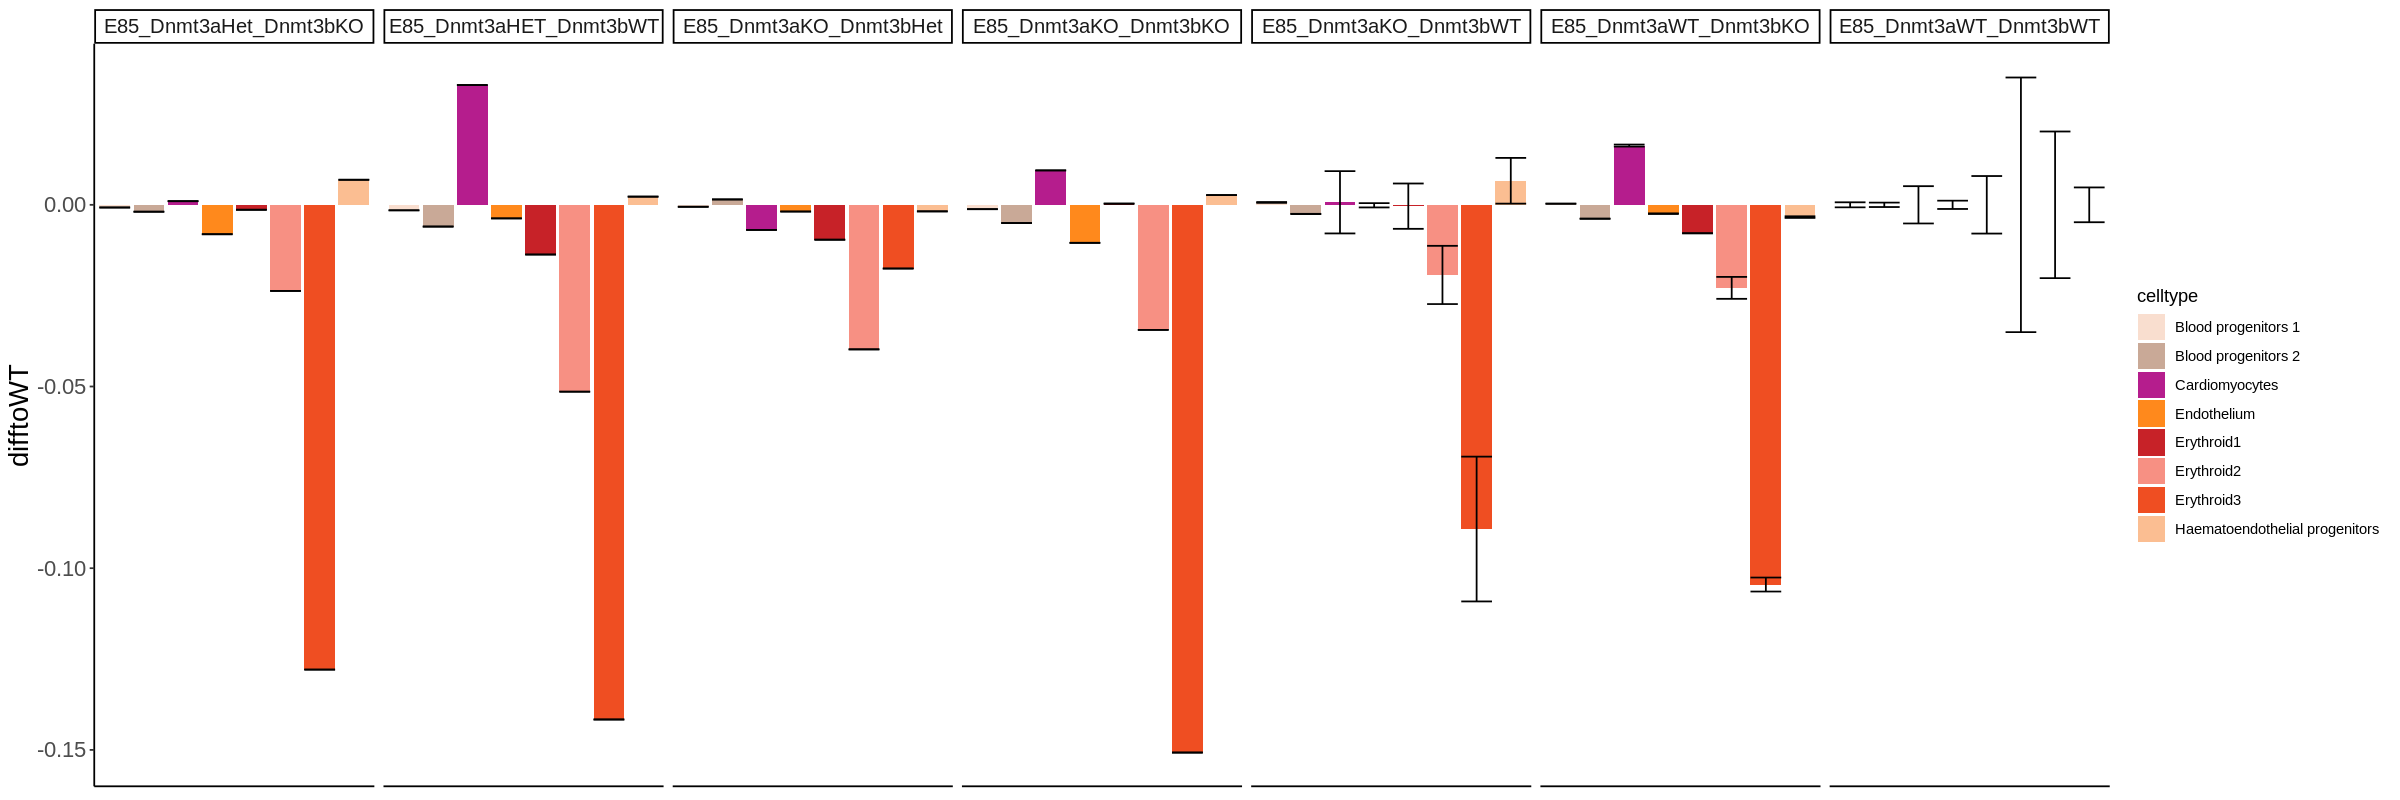

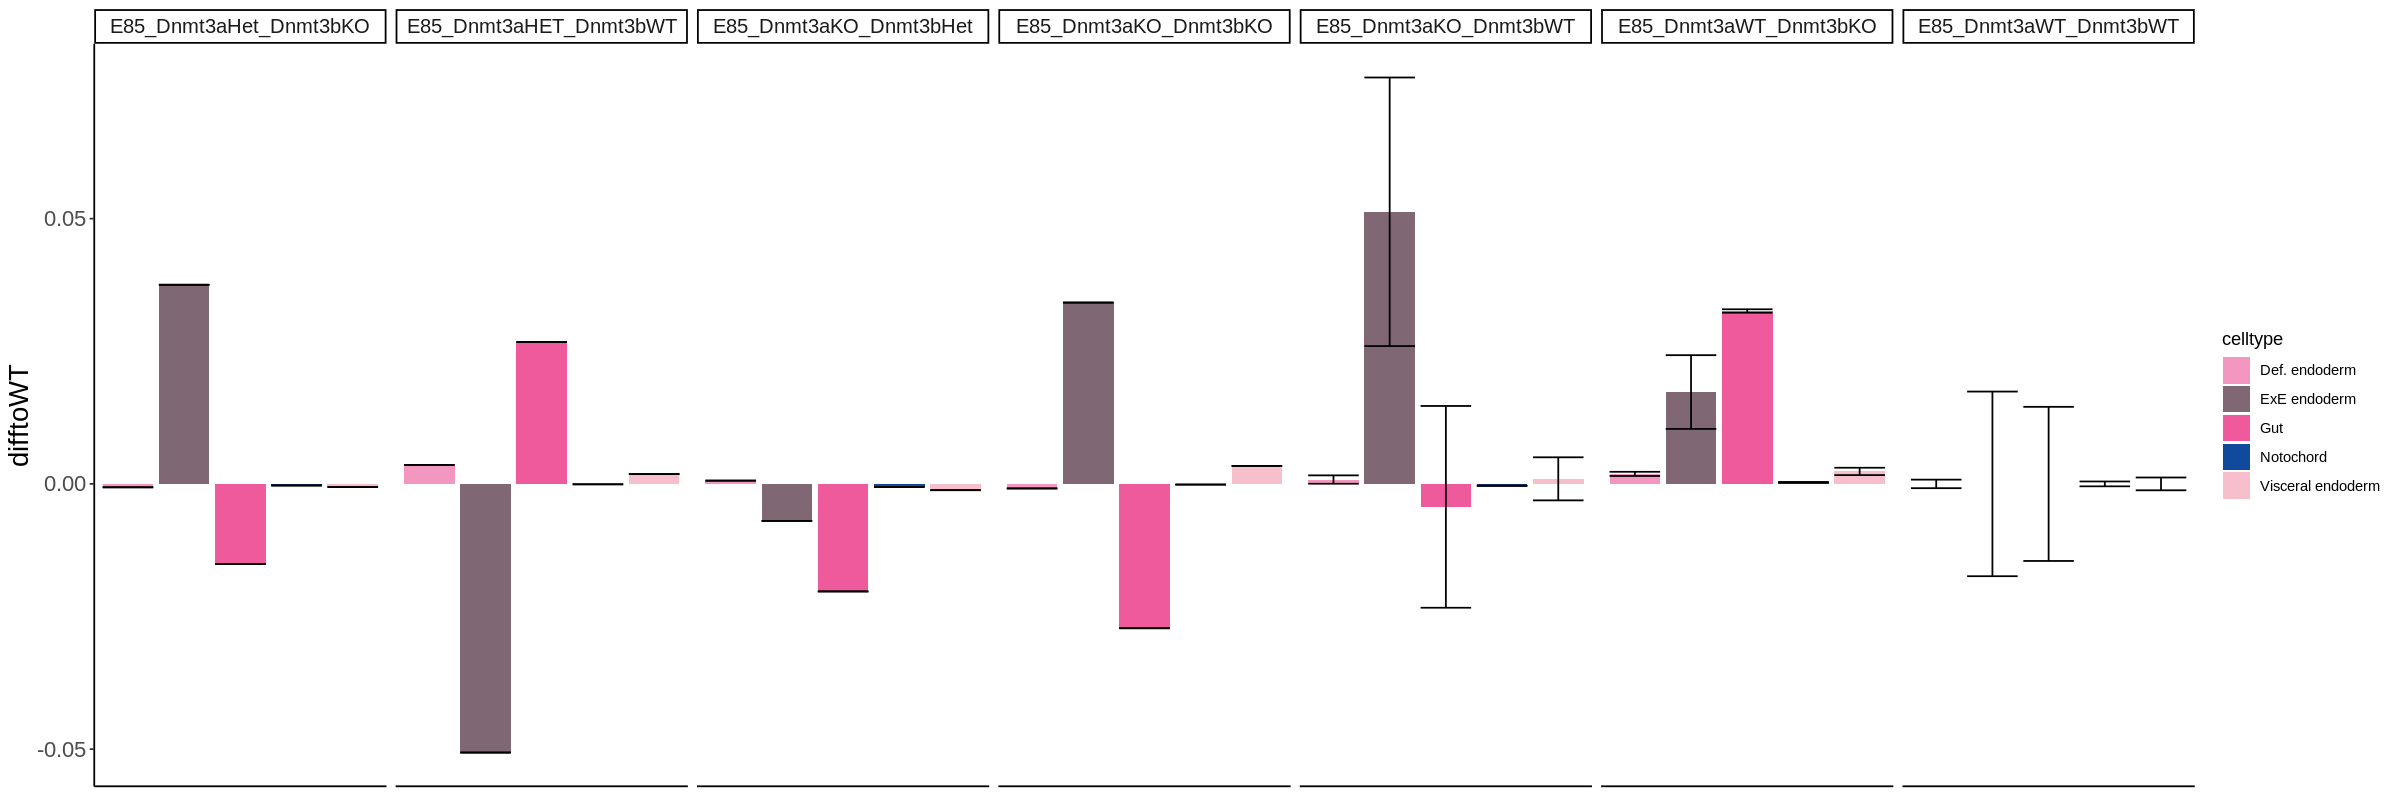

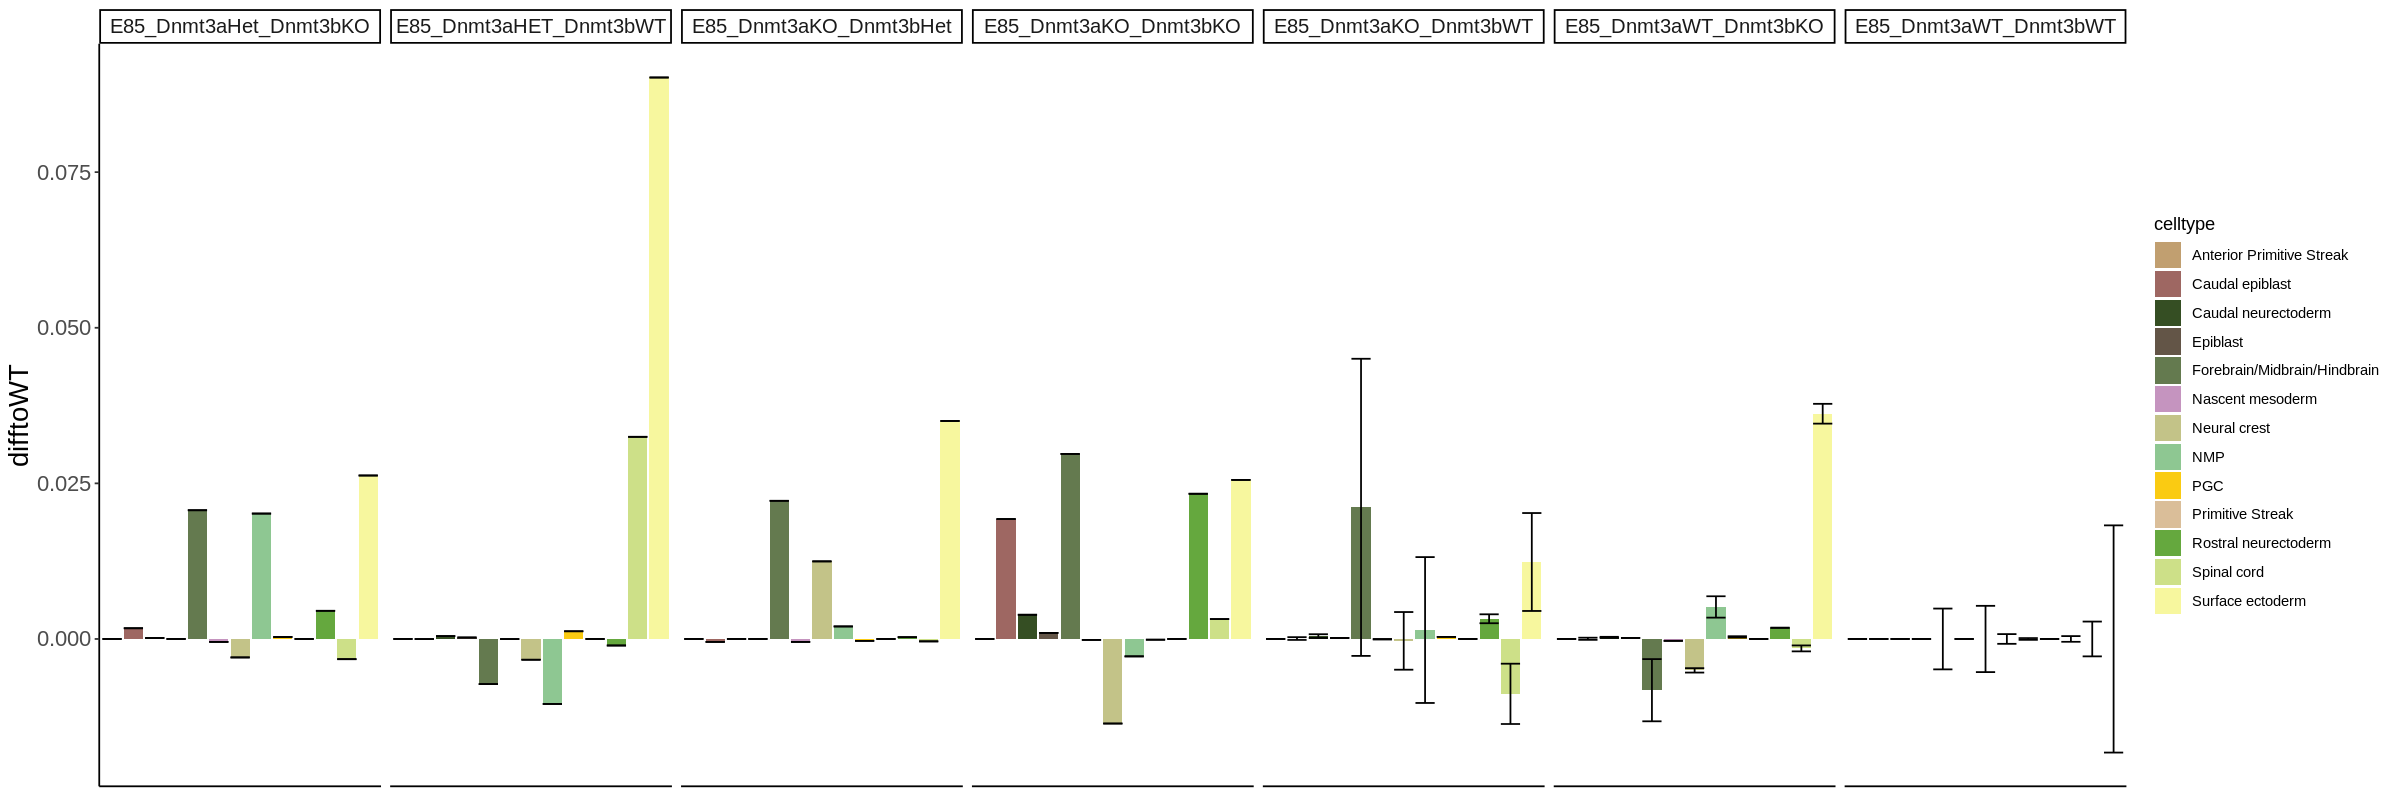

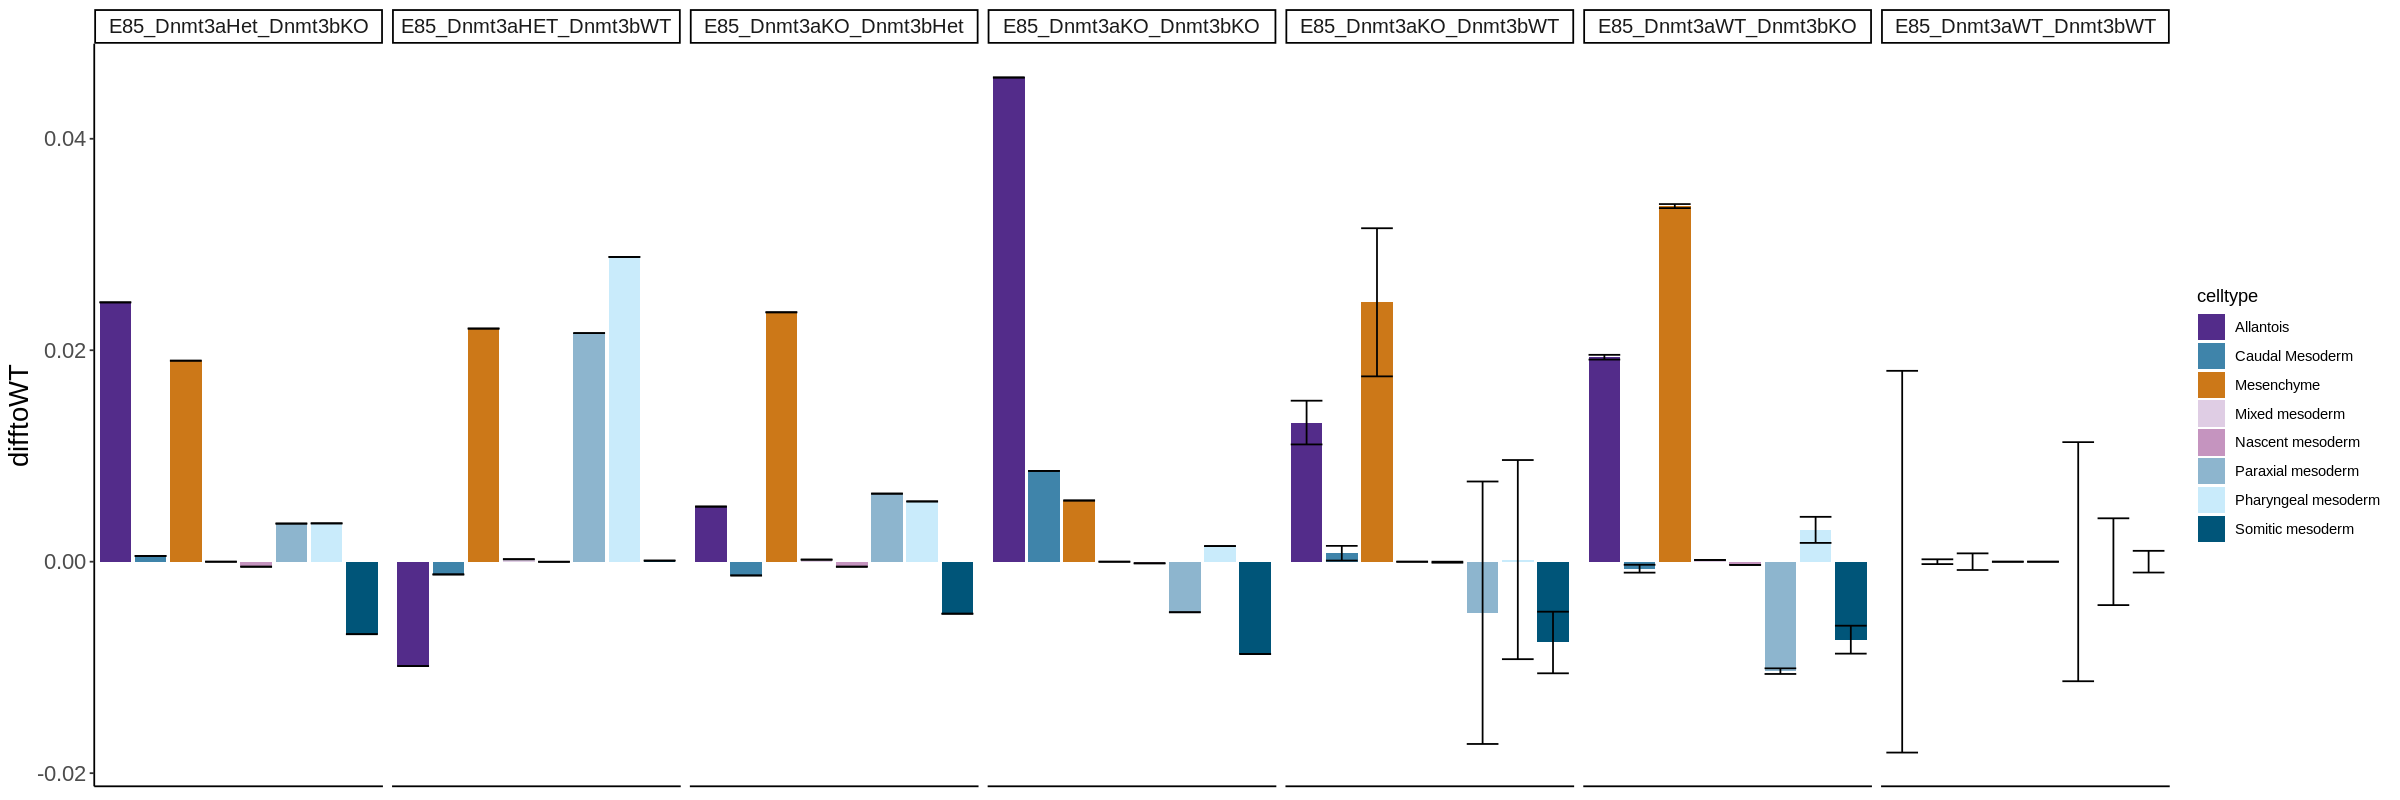

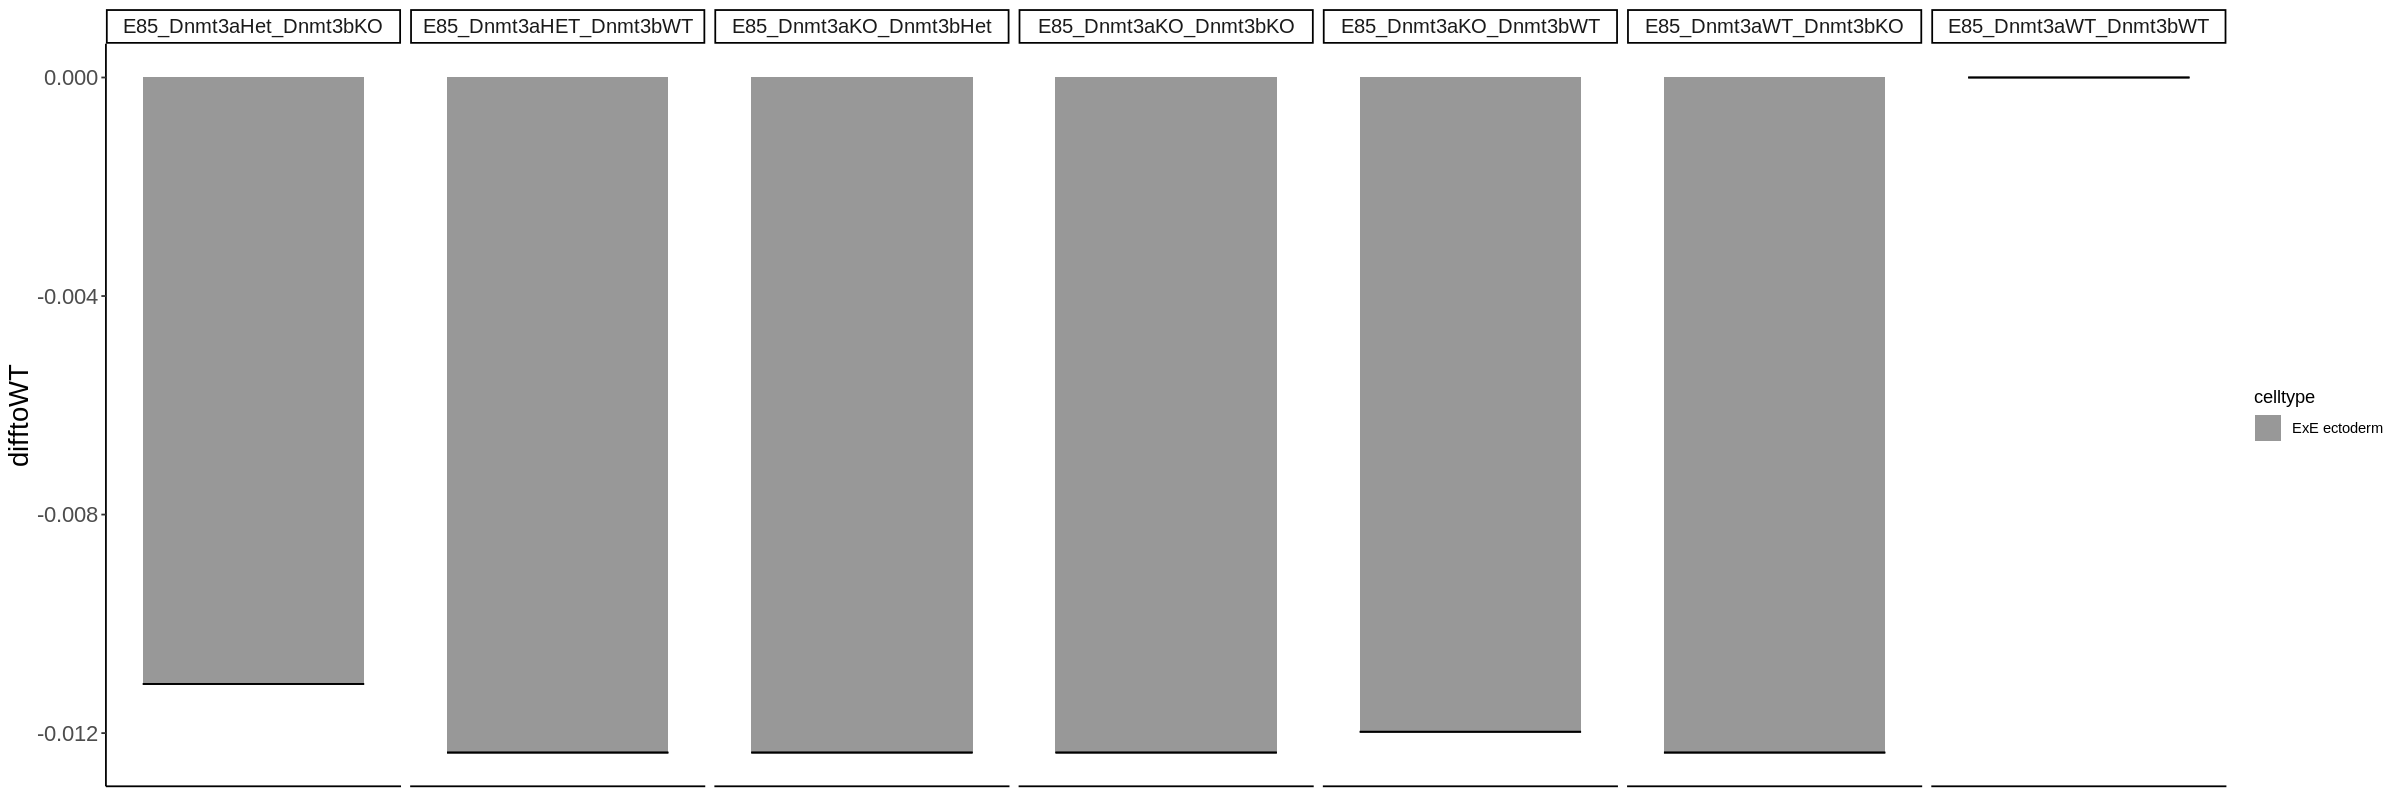

In [261]:
w=20
options(repr.plot.width=w, repr.plot.height=w/3)
for (subset in subset_celltypes) {
    toplot_sub <- toplot[celltype %in% subset]
    if (dim(toplot_sub)[1]>0) {
        p <- ggplot(toplot_sub, aes(x=celltype, y=difftoWT, fill=celltype)) + 
        geom_bar(position="dodge", stat="identity") +
        scale_fill_manual(values=celltype_colours, drop=F) +
        facet_wrap(~class, nrow = 1) +
        theme_classic() +
        geom_errorbar( aes(x=celltype, ymin=difftoWT-diff, ymax=difftoWT+diff)) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank(),
              strip.text=element_text(size=rel(1.1)),
              axis.text.y=element_text(size=rel(1.5)),
              axis.title.y=element_text(size=rel(1.5)))
        print(p)
    }
}

In [280]:
unique(toplot$class)

[1] "E85_Dnmt3aHET_Dnmt3bWT" "E85_Dnmt3aHet_Dnmt3bKO" "E85_Dnmt3aKO_Dnmt3bHet"
[4] "E85_Dnmt3aKO_Dnmt3bKO"  "E85_Dnmt3aKO_Dnmt3bWT"  "E85_Dnmt3aWT_Dnmt3bKO" 
[7] "E85_Dnmt3aWT_Dnmt3bWT"

In [298]:
class_colours = c(
 "E85_Dnmt3aWT_Dnmt3bWT" = "green3",
 "E85_Dnmt3aHET_Dnmt3bWT" = "aquamarine4",
 "E85_Dnmt3aKO_Dnmt3bWT" = "dodgerblue3",
 "E85_Dnmt3aWT_Dnmt3bKO" = "yellow3",
 "E85_Dnmt3aHet_Dnmt3bKO" = "orange",
 "E85_Dnmt3aKO_Dnmt3bHet" = "magenta3",
 "E85_Dnmt3aKO_Dnmt3bKO" = "red"
)

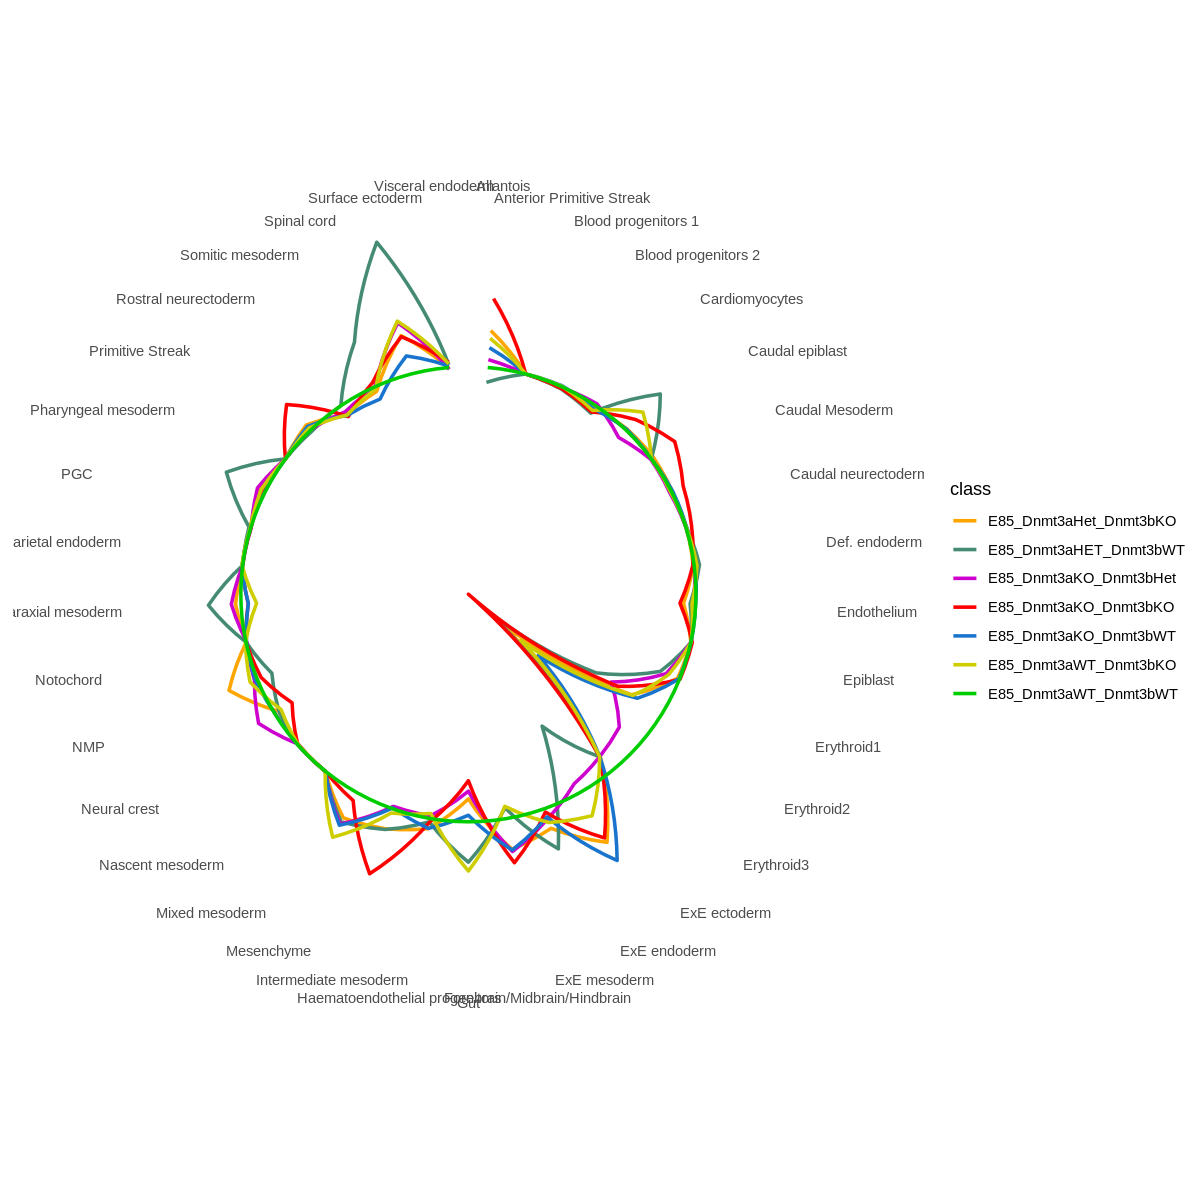

In [382]:
w=10
options(repr.plot.width=w, repr.plot.height=w)
ggplot(toplot, aes(x=celltype, y=difftoWT, fill=celltype, group=class)) + 
    geom_line(aes(color=class),size=1) +
    scale_color_manual(values=class_colours, drop=F) +
    #geom_errorbar( aes(x=celltype, ymin=difftoWT-diff, ymax=difftoWT+diff)) +
    theme_classic() +
    coord_polar() +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.title.x=element_blank(),
          axis.ticks.y=element_blank(),
          axis.line=element_blank())

Warning message in munched_lines$id + rep(c(0, max(ids, na.rm = TRUE)), each = length(ids)):
“longer object length is not a multiple of shorter object length”
Warning message in munched_lines$id + rep(c(0, max(ids, na.rm = TRUE)), each = length(ids)):
“longer object length is not a multiple of shorter object length”
Warning message in munched_lines$id + rep(c(0, max(ids, na.rm = TRUE)), each = length(ids)):
“longer object length is not a multiple of shorter object length”
Warning message in munched_lines$id + rep(c(0, max(ids, na.rm = TRUE)), each = length(ids)):
“longer object length is not a multiple of shorter object length”
Warning message in munched_lines$id + rep(c(0, max(ids, na.rm = TRUE)), each = length(ids)):
“longer object length is not a multiple of shorter object length”
Warning message in munched_lines$id + rep(c(0, max(ids, na.rm = TRUE)), each = length(ids)):
“longer object length is not a multiple of shorter object length”


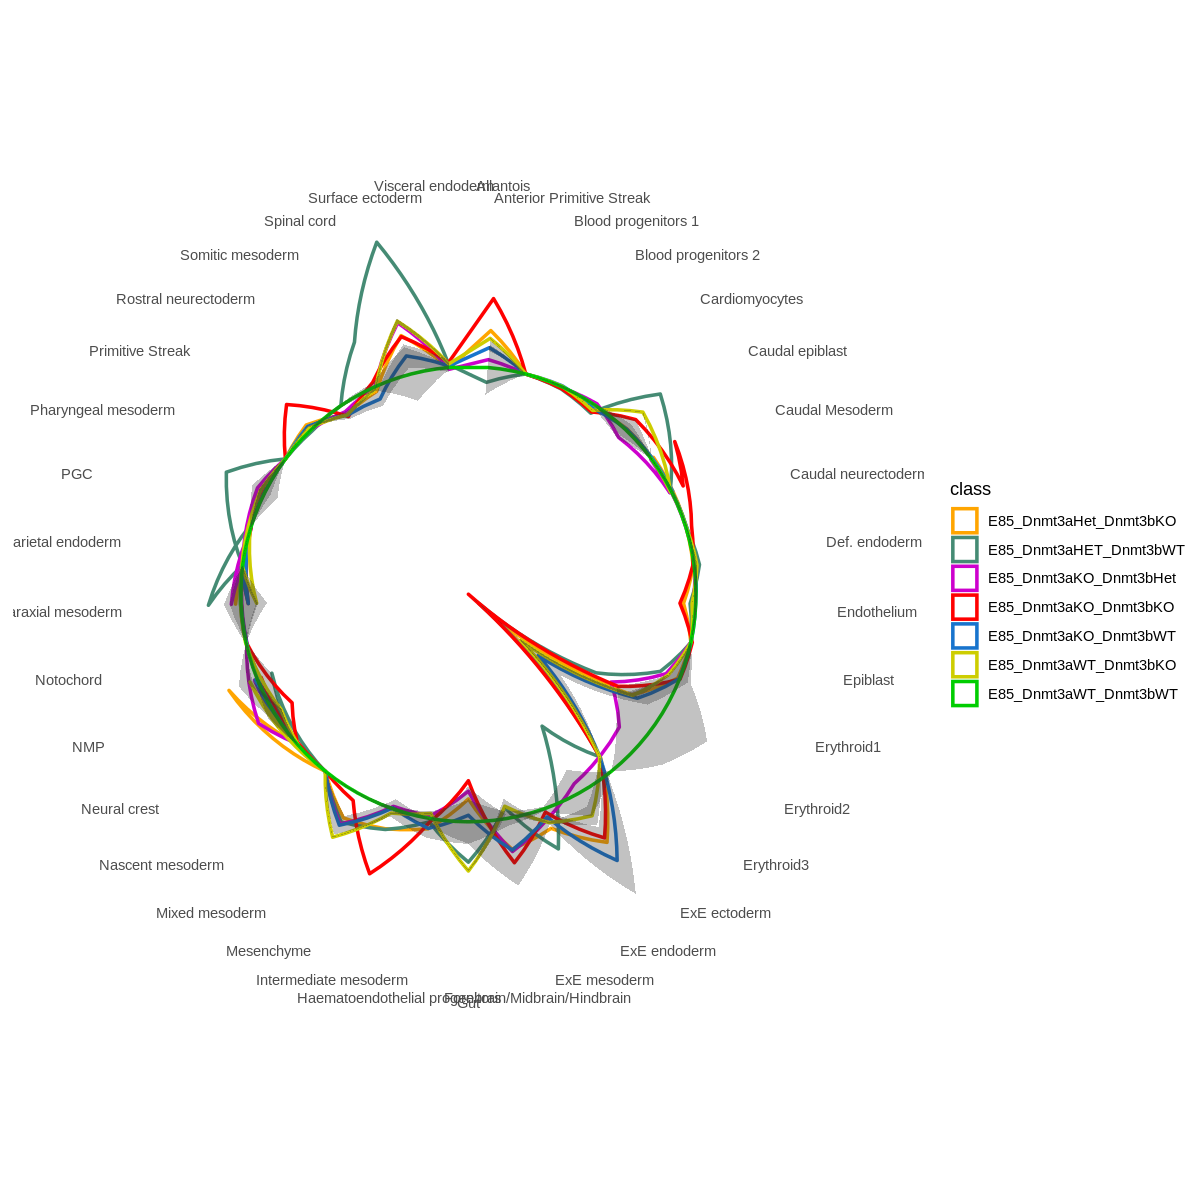

In [384]:
w=10
options(repr.plot.width=w, repr.plot.height=w)
ggplot(toplot) + 
    geom_polygon(aes(y=difftoWT, x=celltype, group=class, colour=class),size=1, fill=NA) +
    scale_color_manual(values=class_colours, drop=F) +
    #geom_errorbar( aes(x=celltype, ymin=difftoWT-diff, ymax=difftoWT+diff)) +
    theme_classic() +
    coord_polar() +
    geom_ribbon(aes(ymin=difftoWTmin, ymax=difftoWTmax, x=celltype, group=class), alpha = 0.3) +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.title.x=element_blank(),
          axis.ticks.y=element_blank(),
          axis.line=element_blank())

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



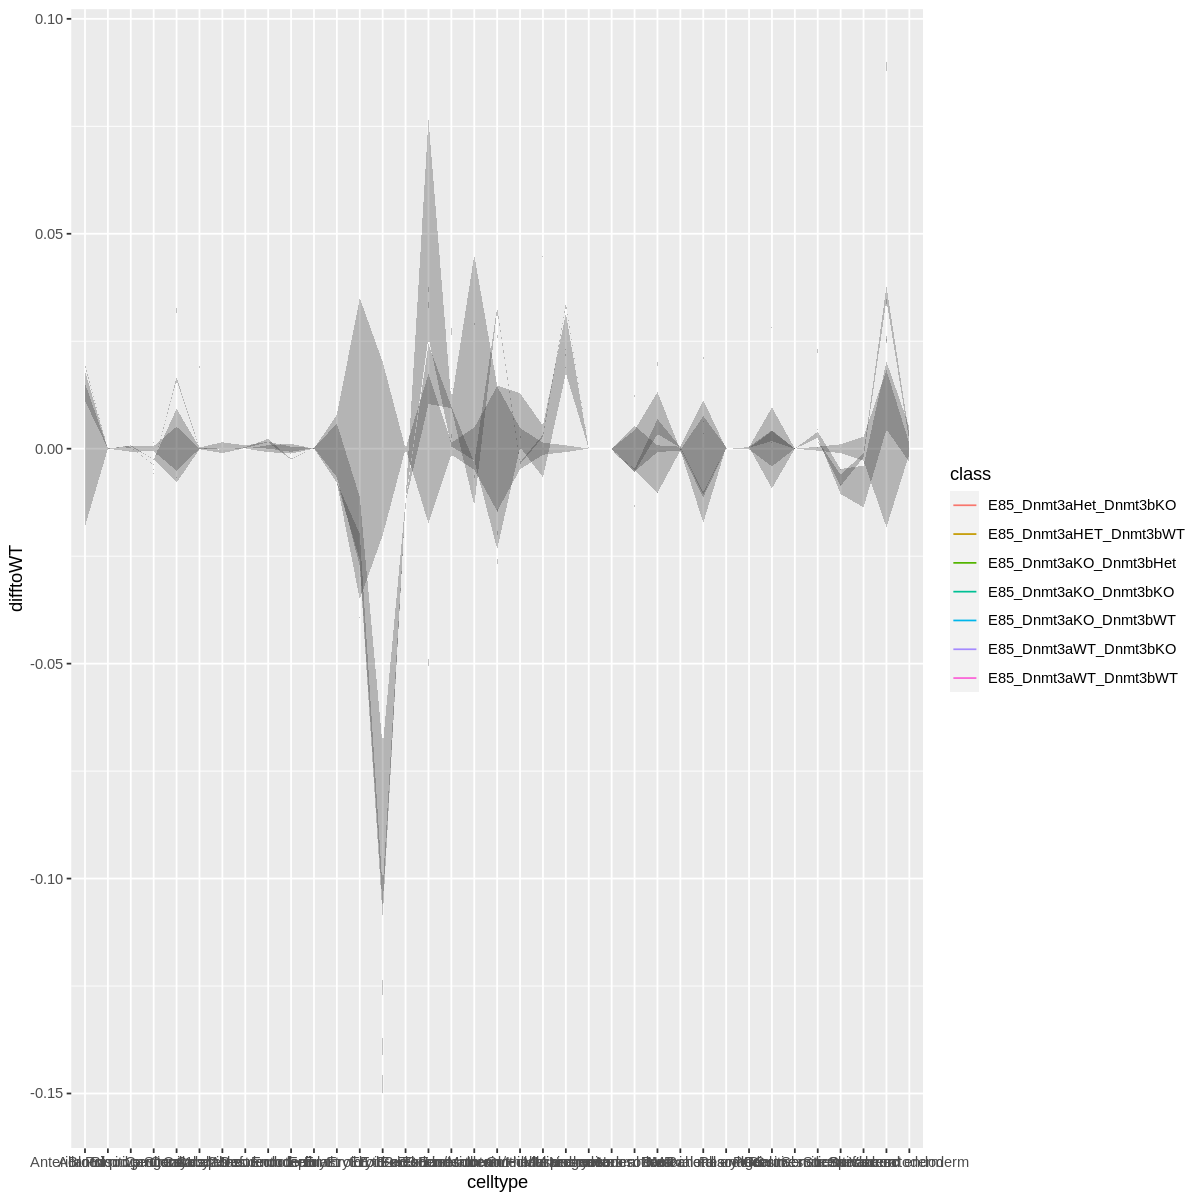

In [372]:
y <- sin(seq(1, 2*pi, length.out = 100))
x <- 1:100
plotdata <- data.frame(x=x, y=y, lower = (y+runif(100, -1, -0.5)), upper = (y+runif(100, 0.5, 1)))

ggplot(toplot) + geom_line(aes(y=difftoWT, x=celltype, colour=class))+
    geom_ribbon(aes(ymin=difftoWTmin, ymax=difftoWTmax, x=celltype, group=class), alpha = 0.3)

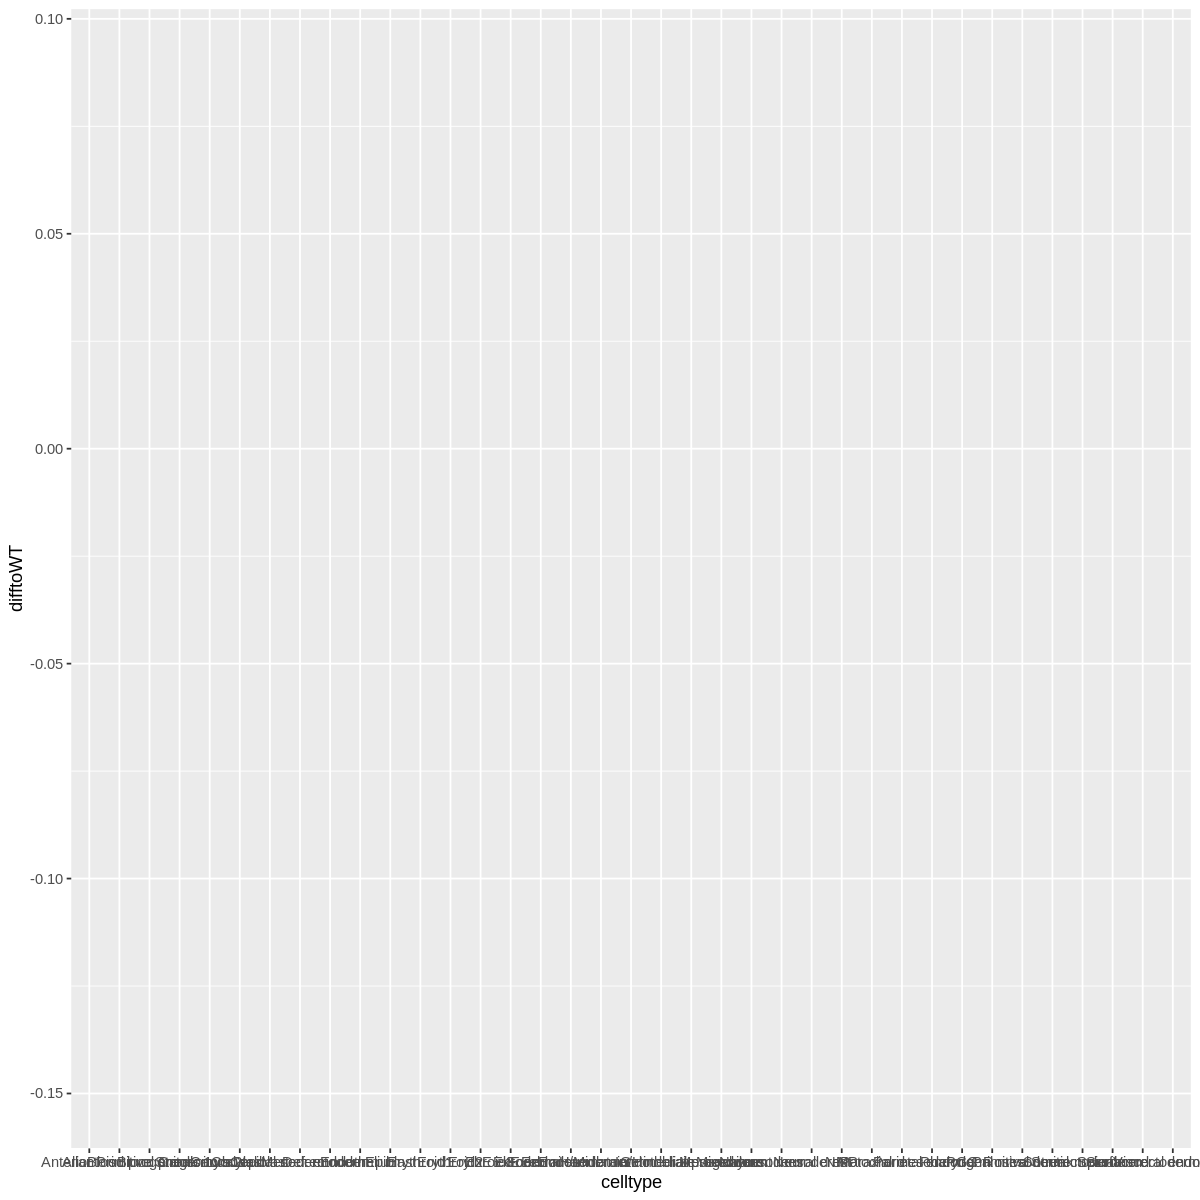

In [350]:
w=10
options(repr.plot.width=w, repr.plot.height=w)
ggplot(toplot, aes(x=celltype, y=difftoWT)) + 
    geom_ribbon(aes(x = celltype, ymin=difftoWT-diff, ymax=difftoWT+diff))

In [347]:
toplot[class=="E85_Dnmt3aWT_Dnmt3bKO"]

class,celltype,mean,diff,difftoWT,logFC
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
E85_Dnmt3aWT_Dnmt3bKO,Allantois,0.0531832090,2.247259e-04,1.933953e-02,0.65208434
E85_Dnmt3aWT_Dnmt3bKO,Anterior Primitive Streak,0.0000000000,0.000000e+00,0.000000e+00,NA
E85_Dnmt3aWT_Dnmt3bKO,Blood progenitors 1,0.0018315061,3.353290e-05,3.141486e-04,0.27146946
E85_Dnmt3aWT_Dnmt3bKO,Blood progenitors 2,0.0021645072,3.962979e-05,-3.815161e-03,-1.46602694
E85_Dnmt3aWT_Dnmt3bKO,Cardiomyocytes,0.0424484960,2.778520e-04,1.631115e-02,0.69960102
E85_Dnmt3aWT_Dnmt3bKO,Caudal Mesoderm,0.0024066369,3.720489e-04,-6.621614e-04,-0.35065533
E85_Dnmt3aWT_Dnmt3bKO,Caudal epiblast,0.0005025501,1.756459e-04,2.876615e-05,0.08503811
E85_Dnmt3aWT_Dnmt3bKO,Caudal neurectoderm,0.0002512751,8.782295e-05,2.512751e-04,NA
E85_Dnmt3aWT_Dnmt3bKO,Def. endoderm,0.0059848746,3.897576e-04,1.889544e-03,0.54734123
